<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/heatexchanger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#@title Calculation of shell and tube heat exchangers
#@markdown This section gives and introduction to design of shell and tube heat exchangers.
%%capture
%pip install neqsim
%pip install ht
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

###Theory
A number of web pages describe the fundamental theory of heat exchange. MIT has published a web course with a [simple introduction to heat treansfer and heat exchangers](http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node131.html). 

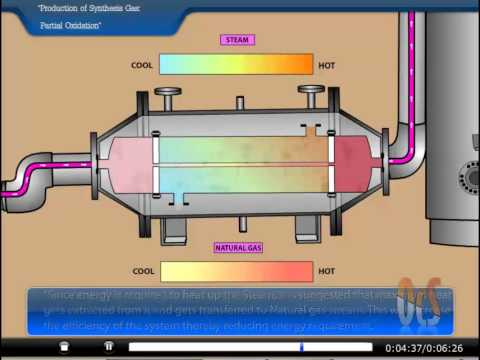

In [7]:
#@title Introduction to shell and tube heat exchangers
#@markdown This video gives introduction to shell and tube heat exchangers
from IPython.display import YouTubeVideo
YouTubeVideo('zUjTa5BajxQ', width=600, height=400)

### Design of a shell and tube heat exchanger

The duty of a heat exchanger is calculated using general equation 

$Q=U \times A \times LMTD $

Where ''Q'' is the exchanged heat duty (in watt), ''U'' is the heat transfer coefficient (in watts per Kelvin per square meter) and ''A'' is the exchange area. LMTD is the [log mean temperature difference](https://en.wikipedia.org/wiki/Logarithmic_mean_temperature_difference) given by the equation:

$LMTD=\frac{\Delta T_A - \Delta T_B}{\ln \left( \frac{\Delta T_A}{\Delta T_B} \right ) }$ 


where $\Delta T_A$ is the temperature difference between the two streams at end ''A'', and $\Delta T_B$ is the temperature difference between the two streams at end ''B''. 

The process simulation will give the necessary duty (Q) for a heat exchanger. 

###Example
1. Estimate the duty of a heat exchager that will cool 1 $MSm^3/day$ of a natural gas at 100 bara from $100 ^\circ C $ to 30 $ ^\circ C $
2. Use a shell and tube heat echanger to cool the gas. Assume an overall heat transfer coefficient of 100 $\frac{W}{m^2 \times K}$. The gas will be cooled using sea water with an inlet temperature of 12  $ ^\circ C $ and an outlet temperature of 80  $ ^\circ C $. Estimate the neccesary heat exchanger area. 

In [8]:
U_Wm2K = 100.0 #@param {type:"number"}
gas_flow = 1.0 #@param {type:"number"}
gas_inlet_pressure = 100.0 #@param {type:"number"}
gas_inlet_temperature = 100.0 #@param {type:"number"}
gas_outlet_temperature = 30.0 #@param {type:"number"}
water_inlet_temperature = 12.0 #@param {type:"number"}
water_outlet_temperature = 80.0 #@param {type:"number"}

from neqsim.thermo import fluid
from neqsim import methods
from neqsim.process import clearProcess, heater, stream, runProcess

# Start by creating a fluid in neqsim
fluid1 = fluid("srk")  # create a fluid using the SRK-Eo
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 85.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 2.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.setMixingRule(2)
fluid1.setTemperature(gas_inlet_temperature, "C")
fluid1.setPressure(gas_inlet_pressure, "bara")
fluid1.setTotalFlowRate(gas_flow, "MSm3/day")

clearProcess()
stream1 = stream(fluid1)
cooler1 = heater(stream1)
cooler1.setOutTemperature(273.15+gas_outlet_temperature)
runProcess()

deltaTA = gas_inlet_temperature-water_outlet_temperature
deltaTB = gas_outlet_temperature-water_inlet_temperature

LMTD = (deltaTA-deltaTB)/(math.log(deltaTA/deltaTB))

Q = -cooler1.getEnergyInput()
A = Q/U_Wm2K/LMTD
print("LMTD ", round(LMTD,3), " degC")
print("heat exchanger duty ", round(cooler1.getEnergyInput()/1e6,3), " MW")
print("heat exchanger area ", round(A,3), " m^2")

LMTD  18.982  degC
heat exchanger duty  -1.935  MW
heat exchanger area  1019.242  m^2


## Use of the Python ht package
https://ht.readthedocs.io/en/release/

ht is open-source software for engineers and technicians working in the fields of chemical or mechanical engineering. It includes modules for various heat transfer functions.

Caleb Bell and Contributors (2016-2021). ht: Heat transfer component of Chemical Engineering Design Library (ChEDL)
https://github.com/CalebBell/ht.


In [52]:
from neqsim.process import heatExchanger
coolingWaterFlow = 100000.0; #kg/hr

fluid1 = fluid("srk")  # create a fluid using the SRK-Eo
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 85.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 2.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.setMixingRule(2)
fluid1.setTemperature(gas_inlet_temperature, "C")
fluid1.setPressure(gas_inlet_pressure, "bara")
fluid1.setTotalFlowRate(gas_flow, "MSm3/day")

fluid2 = fluid("srk")  # create a fluid using the SRK-Eo
fluid2.addComponent("water", 100.0)
fluid2.setMixingRule(2)
fluid2.setTemperature(water_inlet_temperature, "C")
fluid2.setPressure(5.0, "bara")
fluid2.setTotalFlowRate(coolingWaterFlow, "kg/hr")

clearProcess()
hotgasStream = stream(fluid1)
collingWaterStream = stream(fluid2)
coolerHX = heatExchanger(hotgasStream, collingWaterStream, 'HX1')
coolerHX.setUAvalue(U_Wm2K*A) 
runProcess()

print('gas out temperature ' , coolerHX.getOutStream(1).getTemperature('C'))
print(' duty ' , coolerHX.getDuty())


gas out temperature  29.86950892181784
 duty  -2389454.821219723


In [70]:
from ht import *

U = U_Wm2K # W/m^2/K
A = A # m^2
m_gas = hotgasStream.getFlowRate('kg/sec') # kg/s
Cp_gas = hotgasStream.getFluid().getCp('J/kgK') # J/kg/K
Cp_water = collingWaterStream.getFluid().getCp('J/kgK') # J/kg/K
m_water = collingWaterStream.getFlowRate('kg/sec' )# kg/s

Thi = hotgasStream.getTemperature('C')
Tci = collingWaterStream.getTemperature('C')

Cmin = calc_Cmin(mh=m_gas, mc=m_water, Cph=Cp_gas, Cpc=Cp_water)
Cmax = calc_Cmax(mh=m_gas, mc=m_water, Cph=Cp_gas, Cpc=Cp_water)
Cr = calc_Cr(mh=m_gas, mc=m_water, Cph=Cp_gas, Cpc=Cp_water)
NTU = NTU_from_UA(UA=U*A, Cmin=Cmin)
eff = effectiveness_from_NTU(NTU=NTU, Cr=Cr, subtype='crossflow, mixed Cmax')
Q = eff*Cmin*(Thi - coolerHX.getOutStream(0).getTemperature('C'))
Tco = Tci + Q/(m_water*Cp_water)
Tho = Thi - Q/(m_gas*Cp_gas)

Cmin, Cmax, Cr, NTU, eff, Q, Tco, Tho, Q

(26499.53174398009,
 133944.4382623062,
 0.19783973181540765,
 3.846265578987752,
 0.8897308112487075,
 1990348.484754998,
 26.859508245181907,
 24.891182833555305,
 1990348.484754998)